# Modules

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, date, time
import seaborn as sns
from scipy import stats
import scipy.stats as st
import glob
import warnings
from scipy.stats import ttest_rel

from src.utils.data_utils import assign_experience_level
from src.utils.data_utils import clean_location_column

In [4]:
# Suppress certain warnings
warnings.filterwarnings("ignore")

# Dataset

The dataset used in this analysis consists of beer reviews from two beer rating websites,**BeerAdvocate** and **RateBeer**, for a period ranging from 2001 to 2017. For each website, we have 5 files:
- users.csv: metadata about reviewers
- beers.csv : metadata about reviewed beers
- breweries.csv : metadata about breweries
- ratings.txt : all reviews given by users, including numerical ratings and sometimes textual reviews
- reviews.txt : only reviews given by users that include both numerical ratings and textual reviews

In our analysis, we will not use textual reviews. Thus, we will only use ratings.txt files and not reviews.txt files, as we will use all reviews, whether or not they include textual reviews.

### Load data into Dataframes

The .csv files are not too large and can efficiently be loaded into DataFrames.

In [5]:
BA_DATA_FOLDER = 'data/BeerAdvocate/'
RB_DATA_FOLDER = 'data/RateBeer/'

BA_USERS = BA_DATA_FOLDER+"users.csv"
BA_BEERS = BA_DATA_FOLDER+"beers.csv"
BA_BREWERIES = BA_DATA_FOLDER+"breweries.csv"

RB_USERS = RB_DATA_FOLDER+"users.csv"
RB_BEERS = RB_DATA_FOLDER+"beers.csv"
RB_BREWERIES = RB_DATA_FOLDER+"breweries.csv"

In [6]:
ba_users = pd.read_csv(BA_USERS)
ba_beers = pd.read_csv(BA_BEERS)
ba_breweries = pd.read_csv(BA_BREWERIES)

rb_users = pd.read_csv(RB_USERS)
rb_beers = pd.read_csv(RB_BEERS)
rb_breweries = pd.read_csv(RB_BREWERIES)

On the other hand, the ratings.txt files are extremely large, and trying to load them directly into DataFrames leads to kernel freezes. In order to circumvent this problem, we wrote a script (review_parser.py, located in src/scripts), which processes each rating file by dividing it into parts, parsing each part, and saving as JSON. In the notebook, we then load the different JSON files into DataFrames, that we concatenate. Dividing the large .txt files into smaller JSON chunks and then loading each chunk separately, avoids trying to load the entire file into memory at once, which can cause kernel freezes due to memory overload. In addition, JSON is a format that pandas can read efficiently.

In [7]:
# Load BeerAdvocate ratings stored in json files into a single DataFrame
ba_json_files = glob.glob(BA_DATA_FOLDER+'*.json')
ba_df_list = [pd.read_json(file) for file in ba_json_files]
ba_ratings = pd.concat(ba_df_list, ignore_index=True)
ba_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00


In [8]:
# Load RateBeer ratings stored in json files into a single DataFrame
rb_json_files = glob.glob(RB_DATA_FOLDER+'*.json')
rb_df_list = [pd.read_json(file) for file in rb_json_files]
rb_ratings = pd.concat(rb_df_list, ignore_index=True)
rb_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
0,33 Export (Gabon),410549.0,Sobraga,3198.0,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0,2.0
1,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761.0,2.0,3.0,2.0,4.0,8.0,1.9
2,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889.0,3.0,3.0,2.0,3.0,5.0,1.6
3,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510.0,4.0,3.0,1.0,2.0,5.0,1.5
4,Castel Beer (Gabon),105273.0,Sobraga,3198.0,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778.0,2.0,4.0,2.0,4.0,7.0,1.9


### First look at the data

We will now examine the different DataFrames in more detail.

**BeerAdvocate beer Dataframe**

In [9]:
ba_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
226576,258855,Brandy Barrel Aged Oh My Quad,4861,Frankenmuth Brewery,Quadrupel (Quad),1,0,3.78,NaN,NaN,11.0,3.780000,NaN,0,NaN
81830,91236,Brewmaster's Reserve Imperial Red Ale,2710,BJ's Restaurant & Brewery,American Amber / Red Ale,9,1,3.81,NaN,NaN,9.2,3.863333,NaN,0,NaN
111438,222720,Honey White,42015,Merrimack Ales,Witbier,2,0,3.16,NaN,NaN,5.8,3.160000,-1.867373,0,NaN
253884,213212,The Konductor,34209,Iron Spike Brewing Company,Kölsch,0,0,NaN,NaN,NaN,5.1,NaN,NaN,0,NaN


Let us explain the different columns of the BeerAdvocate beer Dataframe, in which each row is a beer:
- beer_id, beer_name, brewery_id, brewery_name, style are explicit
- nbr_ratings: total number of reviews for that beer, whether or not they include textual reviews
- nbr_reviews: number of reviews for that beer that include textual reviews
- avg: average rating (out of 5) given to the beer based on user ratings
- ba_score: the BeerAdvocate score assigned to the beer, which corresponds to the beer's overall rating within its style category, calculated using a trimmed mean and a custom Bayesian formula that adjusts for the beer's style, balancing the score based on the number of ratings and the style's average
- bros_score: beer rating given by the site’s founders
- abv: 'Alcohol by volume', which indicates the percentage of alcohol content in the beer
- avg_computed: average rating (out of 5) recalculated using a weighted sum of the different aspect ratings
- zscore: z-score of the beer's average rating, which is a statistical measure that indicates how many standard deviations the average rating is from the mean of all ratings from the BeerAdvocate dataset
- nbr_matched_valid_ratings: number of valid ratings for beers that were successfully matched between two BeerAdvocate and RateBeer
- avg_matched_valid_ratings: average rating of those matched and valid ratings across the sites

The last two columns are related to the analysis performed by Robert West and Gael Lederrey in the following paper: https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf.

**RateBeer beer Dataframe**

In [10]:
rb_beers.sample(4)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
47499,426877,Ghost Wild Vanilla Scream,10032,Beer Here,Imperial Stout,12,91.0,40.0,3.55,10.3,3.75,NaN,0,NaN
9885,44565,Hek Original Lager Strong Beer (Red Label),412,Groupe Geloso,Imperial Pils/Strong Pale Lager,3,NaN,NaN,2.24,6.2,1.20,NaN,0,NaN
192571,467352,Geaux St. John,17817,Geaux Brewing,Dry Stout,2,NaN,NaN,3.02,5.0,3.20,NaN,0,NaN
20616,428755,Parkside Dim Wit,27360,Parkside Brewing &#40;BC&#41;,Witbier,5,NaN,NaN,2.90,4.9,2.88,NaN,0,NaN


Let us explain the different columns of the RateBeer beer Dataframe, in which each row is a beer:

The beer_id, beer_name, brewery_id, brewery_name, style, nbr_ratings, avg, abv, avg_computed, z-score, nbr_matched_valid_ratings and avg_matched_valid_ratings are the same as for the BeerAdvocate beer Dataframe.

Some columns are missing compared to the BeerAdvocate beer Dataframe: ba_score and bros_score (which makes sense as these are BeerAdvocate-specific scores), and nbr_reviews.

New columns are present compared to the BeerAdvocate beer Dataframe:
- overall_score: score (out of 100) which "reflects the rating given by RateBeer users and how this beer compares to all other beers on RateBeer", calculated by considering the ratings given by each user and the total number of ratings for the beer
- style_score: score given to the beer (out of 100) specifically within its style category

**BeerAdvocate user Dataframe**

In [11]:
ba_users.sample(4)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
60629,28,2,paul432_1.965847,Paul432_1,1.427540e+09,"United States, Pennsylvania"
40446,6,0,thisresa.790600,thisresa,1.395832e+09,"United States, Iowa"
122462,1,0,kmack_11.1175757,KMACK_11,1.475575e+09,"United States, Massachusetts"
132398,1,0,hugo_sbeer.877622,hugo_sbeer,1.413194e+09,NaN


Let us explain the different columns of the BeerAdvocate user Dataframe, in which each row is a reviewer:
- nbr_ratings, nbr_reviews, user_id, user_name, and location are explicit
- joined: timestamp indicating when the user joined BeerAdvocate in Unix timestamp format (the number of seconds since January 1, 1970, 00:00:00 UTC)

**RateBeer user Dataframe**

In [12]:
rb_users.sample(4)

,nbr_ratings,user_id,user_name,joined,location
69757,1,61027,tubbytown,1.190196e+09,NaN
63709,1,62172,nickstpatty,1.191924e+09,NaN
54316,1,239338,FueKarl,1.358593e+09,NaN
14541,1,40297,Dainas,1.153908e+09,"United States, California"


Let us explain the different columns of the RateBeer user Dataframe, in which each row is a reviewer:

The columns are the same as in the BeerAdvocate user Dataframe (joined is obviously the timestamp indicating when the user joined RateBeer and not BeerAdvocate), except that nbr_reviews is missing.

**Brewery Dataframes**

In [13]:
ba_breweries.sample(4)

,id,location,name,nbr_beers
5691,2570,Australia,Hunter Valley Brewing,1
6842,16981,Czech Republic,Pivovar U Bulovky,1
3983,5712,Germany,Bräutigam Brauerei,1
11756,29923,"United States, Minnesota",Northbound Brewpub,60


In [14]:
rb_breweries.sample(4)

,id,location,name,nbr_beers
11590,27250,Slovenia,Majmun,2
3334,20337,Italy,Jungle Juice Brewing,12
1771,13526,Canada,Wild Card Brewing &#40;Ontario&#41;,16
17595,13357,"United States, North Carolina",Mystery Brewing,83


The columns are explicit and are the same for the 2 websites. Each row is a brewery.

**Rating Dataframes**

In [15]:
ba_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
1835368,Sierra Nevada Celebration Ale,1904.0,Sierra Nevada Brewing Co.,140.0,American IPA,6.8,2005-11-20 11:00:00,LPorter33,lporter33.11045,4.00,4.50,4.50,5.00,5.00,4.77
582396,Schneider Weisse Tap 1 Mein Blondes,763.0,Weisses Bräuhaus G. Schneider & Sohn GmbH,72.0,Hefeweizen,4.9,2010-09-01 10:00:00,drpimento,drpimento.6585,3.00,4.00,4.00,4.50,4.50,4.24
7832009,Prairie Bomb! (Double Chocolate),112854.0,Prairie Artisan Ales,30356.0,American Double / Imperial Stout,14.0,2015-01-05 11:00:00,spycow,spycow.205702,4.75,4.75,4.50,4.75,4.50,4.68
7143726,Brrr,45454.0,Widmer Brothers Brewing Company,8.0,Winter Warmer,7.2,2015-08-07 10:00:00,kkawachi,kkawachi.1024634,3.50,3.25,3.25,3.50,3.25,3.37


In [16]:
rb_ratings.sample(4)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating
1760419,Permon Summer Ale American Pale Ale 10°,264252.0,Permon,9670.0,American Pale Ale,4.3,2016-05-15 10:00:00,freretoc,279109.0,4.0,6.0,4.0,5.0,13.0,3.2
6246916,Morland Old Speckled Hen (Filtered),670.0,Greene King,143.0,Premium Bitter/ESB,5.0,2003-01-27 11:00:00,GiddyBoy,2739.0,2.0,6.0,3.0,6.0,13.0,3.0
261513,Wild Rose Dunkel Weisse,109286.0,Wild Rose Brewery,726.0,Dunkelweizen,5.5,2012-08-09 10:00:00,reebtogi,37195.0,3.0,6.0,3.0,7.0,14.0,3.3
4355251,Rock Bottom Arlington Audible Stout,41545.0,Rock Bottom Arlington,4311.0,Dry Stout,3.8,2008-02-29 11:00:00,golubj,49427.0,4.0,5.0,2.0,7.0,13.0,3.1


The columns are the same for the 2 Dataframes. Each row corresponds to an individual review. Most column names are explicit. 
- 'appearance','aroma', 'palate','taste' correspond to aspect ratings (out of 5)
- 'overall' is the mean of the 4 aspect ratings
- 'rating' is the final rating given by the user to the beer

# 0) Data cleaning

### **BASIC CLEANING**

## Filtering Dataframes

Let us start by removing columns in the different Dataframes that we will not use in our analysis.

The following rows will not be used in our analysis:
nbr_reviews, ba_score, bros_score, abv, avg_computed, zscore, nbr_matched_valid_ratings and avg_matched_valid_ratings, overall_score and style_score.

Let us remove them.

In [17]:
useless_columns_ba = ['nbr_reviews', 'ba_score', 'bros_score', 'abv', 'avg_computed', 'zscore', 'nbr_matched_valid_ratings', 'avg_matched_valid_ratings']
ba_beers = ba_beers.drop(columns=useless_columns_ba)
print(ba_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


In [18]:
useless_columns_rb = [col for col in useless_columns_ba if col not in ['nbr_reviews','ba_score', 'bros_score']] + ['overall_score', 'style_score']
rb_beers = rb_beers.drop(columns=useless_columns_rb)
print(rb_beers.columns)

Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg'],
      dtype='object')


We will also not use the timestamps indicating the time when users joined the platforms, so let us remove this as well.

In [19]:
ba_users = ba_users.drop(columns='joined')
rb_users = rb_users.drop(columns='joined')
print(ba_users.columns)

Index(['nbr_ratings', 'nbr_reviews', 'user_id', 'user_name', 'location'], dtype='object')


## Verifying value types

Let us verify that the values in the different columns of the different Dataframes have the appropriate type.

In [20]:
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [21]:
print(ba_users.dtypes,'\n','\n',rb_users.dtypes)

nbr_ratings     int64
nbr_reviews     int64
user_id        object
user_name      object
location       object
dtype: object 
 
 nbr_ratings     int64
user_id         int64
user_name      object
location       object
dtype: object


In [22]:
print(ba_breweries.dtypes,'\n','\n',rb_breweries.dtypes)

id            int64
location     object
name         object
nbr_beers     int64
dtype: object 
 
 id            int64
location     object
name         object
nbr_beers     int64
dtype: object


In [23]:
columns_to_convert = ['beer_name', 'brewery_name', 'style']

ba_beers[columns_to_convert] = ba_beers[columns_to_convert].apply(lambda col: col.astype(str))
rb_beers[columns_to_convert] = rb_beers[columns_to_convert].apply(lambda col: col.astype(str))
print(ba_beers.dtypes,'\n','\n',rb_beers.dtypes)

beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object 
 
 beer_id           int64
beer_name        object
brewery_id        int64
brewery_name     object
style            object
nbr_ratings       int64
avg             float64
dtype: object


In [24]:
print(ba_ratings.dtypes,'\n','\n',rb_ratings.dtypes)

beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                 object
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object 
 
 beer_name               object
beer_id                float64
brewery_name            object
brewery_id             float64
style                   object
abv                    float64
date            datetime64[ns]
user_name               object
user_id                float64
appearance             float64
aroma                  float64
palate                 float64
taste                  float64
overall                float64
rating                 float64
dtype: object


The types of the values in the different columns of the different Dataframes seem appropriate.

## Dealing with missing values

*Beers with no reviews*

Let us verify that all the beers in the beer DataFrames have at least received 1 review.

In [25]:
# get the number of beers with 0 reviews
# Beer Advocate
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)

# Rate Beer
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 32841
Number of beers with no reviews (Rate Beer): 45391


We can see that in Both Dataframes, there are many beers with no reviews. These beers are useless for our analysis and we can remove them from the DataFrames.

In [26]:
# remove beers with zero reviews
# Beer Advocate
ba_beers = ba_beers[ba_beers['nbr_ratings'] != 0]
# Rate Beer
rb_beers = rb_beers[rb_beers['nbr_ratings'] != 0]

# verification:
ba_beers_without_reviews = ba_beers[ba_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Beer Advocate):',ba_beers_without_reviews)
rb_beers_without_reviews = rb_beers[rb_beers['nbr_ratings'] == 0].shape[0]
print('Number of beers with no reviews (Rate Beer):',rb_beers_without_reviews)

Number of beers with no reviews (Beer Advocate): 0
Number of beers with no reviews (Rate Beer): 0


*Reviews with no final rating*

Let us now determine if some reviews lack a final rating. If that is the case, we will remove them from the rating DataFrames as we will need final ratings in our analysis. The final rating, unlike the overall rating, cannot be calculated using aspect ratings, so we cannot retrieve missing final rating values. Some reviews may lack certain aspect ratings, but we will not remove them as if they do have a final rating, we will be able to use them in many parts of our analysis.

In [27]:
# get the number of reviews with Nan in the 'rating' column
# Beer Advocate
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
# Rate Beer
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 2
Number of reviews lacking a final rating (Rate Beer): 2


There are only 2 reviews lacking a final rating for each website, but let us remove them anyway.

In [28]:
# remove reviews with no final rating
ba_ratings = ba_ratings.dropna(subset=['rating'])
rb_ratings = rb_ratings.dropna(subset=['rating'])

# verification 
print('Number of reviews lacking a final rating (Beer Advocate):',ba_ratings['rating'].isna().sum())
print('Number of reviews lacking a final rating (Rate Beer):',rb_ratings['rating'].isna().sum())

Number of reviews lacking a final rating (Beer Advocate): 0
Number of reviews lacking a final rating (Rate Beer): 0


## Cleaning location information

Let us have a closer look at the values present in the 'location' column of user and brewery DataFrames.

In [29]:
ba_users['location'].value_counts()

location
United States, California       11638
United States, Pennsylvania      8689
United States, New York          7432
United States, Illinois          6866
United States, Massachusetts     6658
                                ...  
Angola                              1
Kazakhstan                          1
Tokelau                             1
Sri Lanka                           1
Sint Maarten                        1
Name: count, Length: 194, dtype: int64

In [30]:
rb_users['location'].value_counts()

location
Canada                         3255
United States, California      2804
England                        2734
Poland                         1701
United States, Pennsylvania    1632
                               ... 
Liechtenstein                     1
Lesotho                           1
East Timor                        1
Falkland Islands                  1
Tibet                             1
Name: count, Length: 222, dtype: int64

In [31]:
ba_breweries['location'].value_counts()

location
Germany                                                                                                                                                                          1431
England                                                                                                                                                                           997
United States, California                                                                                                                                                         929
Canada                                                                                                                                                                            775
United States, Washington                                                                                                                                                         411
                                                                                 

In [32]:
rb_breweries['location'].value_counts()

location
England                      2124
Germany                      1999
Italy                        1051
Canada                        884
United States, California     867
                             ... 
Senegal                         1
Mozambique                      1
French Polynesia                1
Papua New Guinea                1
Gabon                           1
Name: count, Length: 267, dtype: int64

We can make 2 important observations: US locations all contain state information, and some locations contain embedded HTML links. We will remove both these HTML links and the state information, as we will not use it in our analysis. We will do so by applying a function named 'clean_location_column' which cleans the location information and that we have written in src/utils/data_utils.py().

In [33]:
# Clean location information in user and brewery dataframes
# Beer Advocate
ba_users = clean_location_column (ba_users)
ba_breweries = clean_location_column (ba_breweries)

# Rate Beer
rb_users = clean_location_column (rb_users)
rb_breweries = clean_location_column (rb_breweries)

Let us now have a look at the cleaned location columns.

In [34]:
ba_users['location'].value_counts()

location
United States                               113223
nan                                          31279
Canada                                        3324
England                                        791
Australia                                      520
                                             ...  
South Georgia and South Sandwich Islands         1
Angola                                           1
Kazakhstan                                       1
Egypt                                            1
Sint Maarten                                     1
Name: count, Length: 146, dtype: int64

In [35]:
rb_users['location'].value_counts()

location
United States       26855
nan                 19582
Canada               3255
England              2734
Poland               1701
                    ...  
Honduras                1
Falkland Islands        1
Kyrgyzstan              1
Papua New Guinea        1
Tibet                   1
Name: count, Length: 174, dtype: int64

In [36]:
ba_breweries['location'].value_counts()

location
United States            7399
Germany                  1431
England                   997
Canada                    775
France                    402
                         ... 
Equatorial Guinea           1
Tajikistan                  1
Palau                       1
French Guiana               1
Sao Tome and Principe       1
Name: count, Length: 212, dtype: int64

In [37]:
rb_breweries['location'].value_counts()

location
United States            6921
England                  2124
Germany                  1999
Italy                    1051
Canada                    884
                         ... 
Sao Tome and Principe       1
Iraq                        1
Micronesia                  1
French Guiana               1
Gabon                       1
Name: count, Length: 217, dtype: int64

### **'LOCATION-SPECIFIC' CLEANING**

Several parts of our analysis will involve comparing data from different countries and will require working with the location information in the user DataFrames. In these parts, we will only consider countries with a 'sufficiently large' number of reviewers, as only a few reviewers may not be representative of an entire country. We will thus filter out countries that we consider to have not enough reviewers. We decide arbitrarily to filter out countries with less than 10 different reviewers.

In this part of the data cleaning, we will work on a copy of the original DataFrames, and we will use these copies only for the parts of the analysis where we compare certain countries. Indeed, this filtering is not relevant for the parts that do not involve comparing certain countries.

In [40]:
# create copies of the user and rating DataFrames, which will undergo filtering related to the location information
ba_users_loc_filtered = ba_users.copy()
rb_users_loc_filtered = rb_users.copy()
ba_ratings_loc_filtered = ba_ratings.copy()
rb_ratings_loc_filtered = rb_ratings.copy()

## Removing users with missing location information

First, let us determine if some users are missing the location information.

In [43]:
# get the number of users with 'nan' in the 'location' column
# Beer Advocate
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
# Rate Beer
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 31279
Number of users lacking the location information (Rate Beer): 19582


We can see that there are indeed some users missing the location information. Let us remove these users.

In [45]:
# remove users with 'nan' in the 'location' column
ba_users_loc_filtered = ba_users_loc_filtered[ba_users_loc_filtered['location'] != 'nan']
rb_users_loc_filtered = rb_users_loc_filtered[rb_users_loc_filtered['location'] != 'nan']

# verification
print('Number of users lacking the location information (Beer Advocate):',ba_users_loc_filtered[ba_users_loc_filtered['location'] == 'nan'].shape[0])
print('Number of users lacking the location information (Rate Beer):',rb_users_loc_filtered[rb_users_loc_filtered['location'] == 'nan'].shape[0])

Number of users lacking the location information (Beer Advocate): 0
Number of users lacking the location information (Rate Beer): 0


## Filtering out users and reviews written by users from countries with too few users

Let us first identify the countries with a number of users that is smaller than the threshold we set earlier, that is, 10 users.

In [50]:
# concatenate the 'location' columns from the 2 user dataframes
combined_locations = pd.concat([ba_users_loc_filtered['location'], rb_users_loc_filtered['location']])

# get the counts of each unique value in 'location'
location_counts = combined_locations.value_counts()

# keep only locations with less than 10 counts
locations_with_few_counts = location_counts[location_counts < 10]

# Get the list of location values with less than 10 counts
countries_with_few_users = locations_with_few_counts.index.tolist()

print("Countries with less than 10 users across both DataFrames:")
print(countries_with_few_users)

Countries with less than 10 users across both DataFrames:
['Antarctica', 'Cayman Islands', 'Bermuda', 'Bolivia', 'Honduras', 'Montenegro', 'Egypt', 'Tanzania', 'Uganda', 'Botswana', 'Zimbabwe', 'Albania', 'Tajikistan', 'Azerbaijan', 'Trinidad and Tobago', 'American Samoa', 'Tunisia', 'Jersey', 'Vanuatu', 'Pakistan', 'Jordan', 'Mauritius', 'Belize', 'Nicaragua', 'Barbados', 'Mozambique', 'Aruba', 'Uzbekistan', 'Nigeria', 'Palestine', 'Namibia', 'Abkhazia', 'Papua New Guinea', 'Armenia', 'Morocco', 'Nepal', 'Burkina Faso', 'Marshall Islands', 'Ascension Island', 'Vatican City', 'Hawaii', 'Algeria', 'Kosovo', 'Laos', 'Monaco', 'Bangladesh', 'Sint Maarten', 'Norfolk Island', 'Ghana', 'Slovakia', 'Saint Helena', 'Dem Rep of Congo', 'San Marino', 'Zambia', 'Iraq', 'Syria', 'Northern Mariana Islands', 'Kazakhstan', 'New Caledonia', 'Fiji Islands', 'Bouvet Island', 'Lesotho', 'Guernsey', 'Svalbard and Jan Mayen Islands', 'Bhutan', 'Ethiopia', 'Haiti', 'Antigua and Barbuda', 'Kyrgyzstan', 'Iran

Let us determine if filtering out these 113 countries would leave us with enough data, ie with enough countries, to perform our analysis comparing different countries.

In [47]:
print('Remaining countries after filtering:',(len(location_counts)-len(locations_with_few_counts)))

Remaining countries after filtering: 88


Filtering out those countries would leave us with 88 countries, which is enough to perform our analysis.

Ultimately, we would like to remove reviews from users coming from countries with too few reviewers. 
To do so, we will start by adding the user location information to review DataFrames. This will facilitate the filtering and analysis.

In [48]:
# merge rating dataframes with user dataframes on 'user_id' to add the'location' column to rating dataframes as 'user_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'user_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_users_loc_filtered[['user_id', 'location']], on='user_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'user_location'})

ba_ratings_loc_filtered.head()

       beer_name   beer_id                               brewery_name  \
0          Régab  142544.0  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew   19590.0       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv                date        user_name  \
0     37262.0   Euro Pale Lager  4.5 2015-08-20 10:00:00          nmann08   
1     10093.0  English Pale Ale  4.5 2009-02-20 11:00:00      StJamesGate   
2     10093.0  English Pale Ale  4.5 2006-03-13 11:00:00          mdagnew   
3     10093.0  English Pale Ale  4.5 2004-12-01 11:00:00  helloloser12345   
4     10093.0  English Pale Ale  4.5 2004-08-30 10:00:00       cypressbob   

                 user_id  appearance  aroma  palate  taste  overall  rating  \
0         nmann08.1

We now must remove the reviews from users whose location is NaN. Such users correspond to the users lacking a ocation information that have been previously removed from the user dataframes, but which are still present in the review dataframes.

In [55]:
# remove reviews from users for which the location is NaN
ba_ratings_loc_filtered = ba_ratings_loc_filtered.dropna(subset=['user_location'])
rb_ratings_loc_filtered = rb_ratings_loc_filtered.dropna(subset=['user_location'])

We can now remove reviews from users coming from countries with too few reviewers.

In [58]:
# remove reviews where 'user_location' is in the 'countries_with_few_users' list
ba_ratings_loc_filtered = ba_ratings_loc_filtered[~ba_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]
rb_ratings_loc_filtered = rb_ratings_loc_filtered[~rb_ratings_loc_filtered['user_location'].isin(countries_with_few_users)]

We will now remove users coming from countries with too few reviewers from the user dataframes.

In [61]:
# remove users for which 'location' is in the 'countries_with_few_users' list
ba_users_loc_filtered = ba_users_loc_filtered[~ba_users_loc_filtered['location'].isin(countries_with_few_users)]
rb_users_loc_filtered = rb_users_loc_filtered[~rb_users_loc_filtered['location'].isin(countries_with_few_users)]

## Adding brewery location information to filtered review DataFrames

Finally, to facilitate our analysis, we will add the brewery location information for each beer reviewed in the review dataframes. 

In [64]:
ba_breweries_loc_filtered = ba_breweries.copy()
rb_breweries_loc_filtered = rb_breweries.copy()

In [65]:
# rename 'id' column to 'brewerie_id' column in brewery dataframes to facilitate merging with rating dataframes
ba_breweries_loc_filtered = ba_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})
rb_breweries_loc_filtered = rb_breweries_loc_filtered.rename(columns={'id': 'brewery_id'})

# merge rating dataframes with brewery dataframes on 'brewery_id' to add the'location' column to rating dataframes as 'brewerie_location'

# Beer Advocate
ba_ratings_loc_filtered = ba_ratings_loc_filtered.merge(ba_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
ba_ratings_loc_filtered = ba_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

# Rate Beer
rb_ratings_loc_filtered = rb_ratings_loc_filtered.merge(rb_breweries_loc_filtered[['brewery_id', 'location']], on='brewery_id', how='left')
rb_ratings_loc_filtered = rb_ratings_loc_filtered.rename(columns={'location': 'brewery_location'})

ba_ratings_loc_filtered.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,user_location,brewery_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,United States,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,United States,Northern Ireland
2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland,Northern Ireland
3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland,Northern Ireland
4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland,Northern Ireland


# 1) Link between culture and taste

## a) Beer style preferences

In [54]:
# use clustering techniques to determine beer style is most popular in each country / geographic area
# use time information to determine if regional beer style preferences are stable (which would suggest that they are 
# strongly affected by culture)or if they vary over time

## b) Importance of specific beer attributes

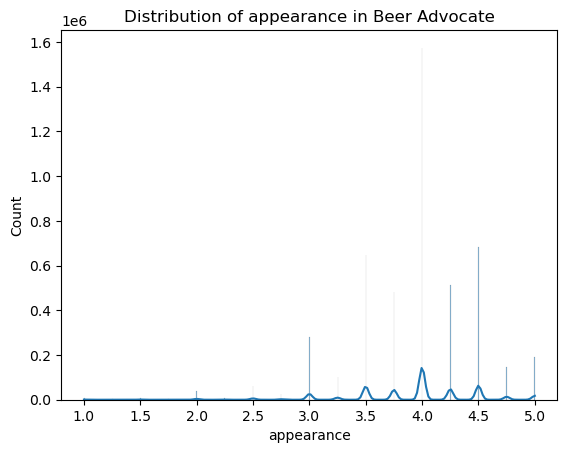

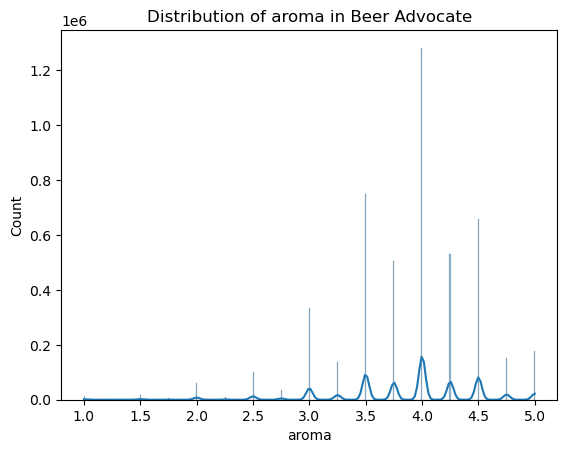

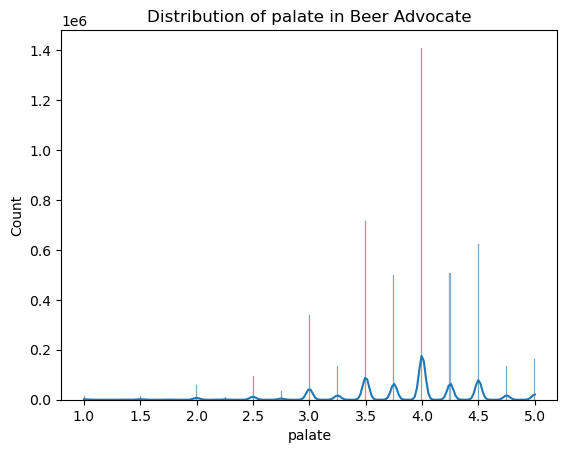

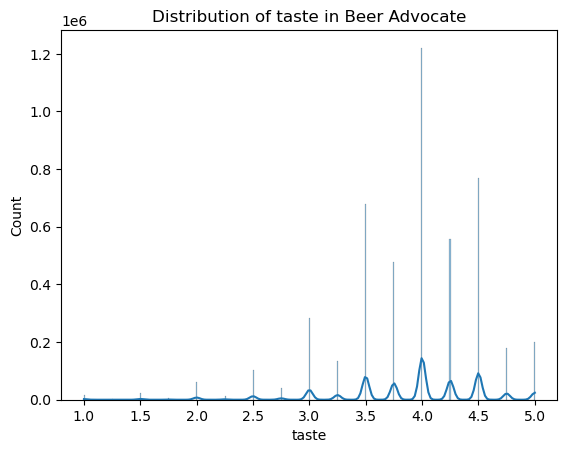

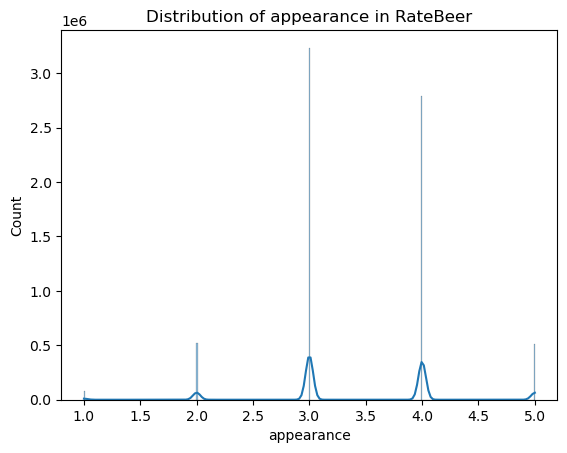

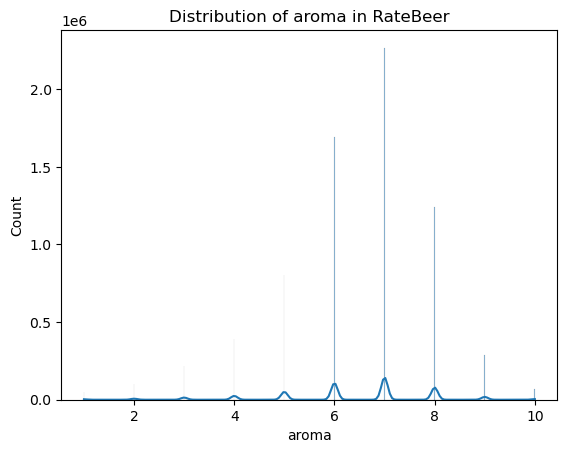

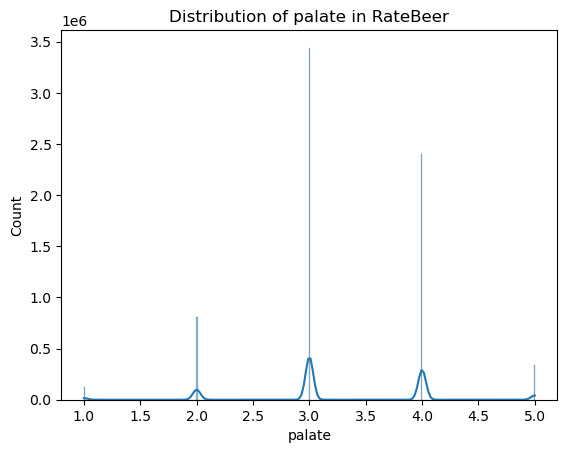

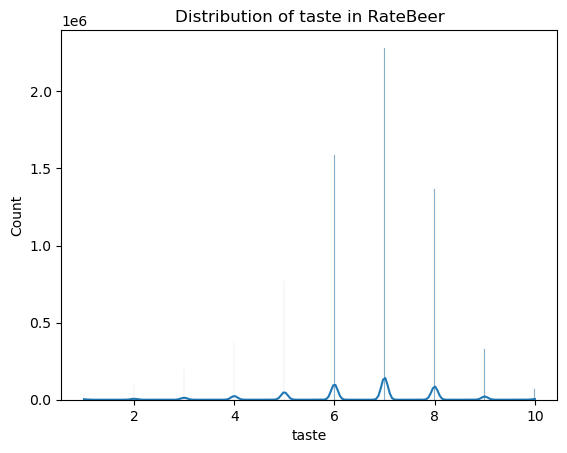

In [55]:
# perform linear regression between attribute ratings the final rating for all countries together and compare coefficients for each attribute
# perform linear regression between attribute ratings the final rating for the different countries separately and observe the distribution of the coefficients for the different attributes across countries

# Don't forget to do these kind of analysis also after merging the two different dataframes from different files
# Firstly we visualize the distrubtion of the ratings for different  beer attributes
attributes = ['appearance', 'aroma', 'palate', 'taste']  #
for col in attributes:
    plt.figure()
    sns.histplot(ba_ratings_[col], kde=True)
    plt.title(f"Distribution of {col} in Beer Advocate")
for col in attributes:
    plt.figure()
    sns.histplot(rb_ratings_[col], kde=True)
    plt.title(f"Distribution of {col} in RateBeer")

In [56]:
# We will try to see and compare how each attributes correlates between each other 
correlation_matrix_1 = ba_ratings_[attribute_columns].corr()
print("Correlation matrix:\n", correlation_matrix_1)

# Creating the plot of the correlation matrix for both data 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="cividis")
plt.title("Correlation Matrix of different attributes in Beer Advocate")

correlation_matrix_2 = rb_ratings_[attribute_columns].corr()
print("Correlation matrix:\n", correlation_matrix_2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_2, annot=True, cmap="viridis")
plt.title("Correlation Matrix of different attributes in Rate Beer")
plt.show()
plt.close()

NameError: name 'attribute_columns' is not defined

As we see from the plots and correlation matrix the different attributes of the beers generally correlates. The biggest correlation is between the palate and taste which is logical because the beers with richest palate tends to taste better.

# 2) Location-related biases in ratings

## a) Cultural biases

In [ ]:
# determine the final rating for each country/ geographic area
# determine if the final rating for each country/ geographic area is the same using statistical tests

## b) Beer origin bias

In [47]:
# compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# IMPORTANT NOTE: for the following task, do the following:
# 1) for each rating dataframe, perform a value_count on the 'user_location' column: the values correspond to countries that we considered to have enough reviewers
# 2) create a copy of the beer dataframes to remove beers whose brewerie is not in one of the countries identified above
# task in question: determine if the final rating of a given beer is correlated with the number of reviewers from the country where the beer comes from who reviewed that beer (scatter plot + Pearson’s correlation coefficient + regression)

# isolate beer enthusiasts (who wrote a very large number of reviews) and compare the final rating of domestic vs foreign beers and determine if there is a significant difference using statistical tests

# 3) Other biases

## a) Seasonal biases

In [ ]:
# use the time information to determine the season during which each rating was posted (only consider countries with 4 seasons)
# group ratings by season
# within each group, determine the average final rating of each beer style
# compare the results for the different seasons

This function categorizes each month into a season to identify when each beer rating was posted. We’re only considering countries with four seasons.

In [ ]:
# determine season based on date
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

Here, we apply the get_season function to add a 'season' column to both ba_ratings_ (BeerAdvocate) and rb_ratings_ (RateBeer) datasets, ensuring each rating has its respective season assigned.

In [ ]:
# Add season information to ratings dataframes
ba_ratings_['season'] = ba_ratings_['date'].apply(lambda x: get_season(pd.to_datetime(x)))
rb_ratings_['season'] = rb_ratings_['date'].apply(lambda x: get_season(pd.to_datetime(x)))

This code block generates boxplots showing the distribution of ratings by season for each platform, providing a visual sense of seasonal variation in ratings.

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=ba_ratings_, palette="Set2")
plt.title("BeerAdvocate: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Rating")
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='rating', data=rb_ratings_, palette="Set1")
plt.title("RateBeer: Ratings Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Rating")
plt.show()
plt.close()

This part calculates the average rating for each season on both platforms and then combines these into a single DataFrame for easier comparison

In [ ]:
# Group by season, then calculate average final rating within each season
ba_seasonal_avg = ba_ratings_.groupby('season')['rating'].mean().reset_index()
rb_seasonal_avg = rb_ratings_.groupby('season')['rating'].mean().reset_index()

In [ ]:
# Combine BeerAdvocate and RateBeer seasonal averages
seasonal_avg = pd.concat([ba_seasonal_avg, rb_seasonal_avg], keys=['BeerAdvocate', 'RateBeer']).reset_index(level=0).rename(columns={'level_0': 'source'})
seasonal_avg = seasonal_avg.groupby(['season', 'source'])['rating'].mean().unstack()

In [ ]:
print("Seasonal Bias Analysis - Average Ratings per Style by Season")
display(seasonal_avg)

Both BeerAdvocate and RateBeer show slight variations in ratings across seasons. Average ratings on BeerAdvocate are relatively stable, with minor variations, while RateBeer ratings show a bit more fluctuation across seasons. Winter and Spring generally have slightly higher ratings than Summer and Fall, possibly due to seasonal preferences for richer or stronger beers that are typically enjoyed in cooler weather.

In [ ]:
# Plot average ratings across seasons
seasonal_avg.plot(kind='bar', figsize=(10, 6))
plt.title("Average Ratings by Season Across BeerAdvocate and RateBeer")
plt.xlabel("Season")
plt.ylabel("Average Rating")
plt.legend(title='Source')
plt.show()
plt.close()

BeerAdvocate ratings tend to be consistently higher than those on RateBeer across all seasons, which might reflect differences in user base preferences or rating scales.

In [ ]:
# Correlation matrix for seasonal ratings between BeerAdvocate and RateBeer
correlation_matrix = seasonal_avg.corr()
print("Correlation Matrix of Seasonal Ratings between BeerAdvocate and RateBeer")
display(correlation_matrix)

In [ ]:
# Heatmap of correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Seasonal Ratings")
plt.show()
plt.close()

The high correlation (0.97) between BeerAdvocate and RateBeer seasonal ratings indicates that both platforms exhibit similar seasonal patterns, despite variations in their absolute values. This strong correlation suggests a shared trend in beer preferences among users, regardless of platform differences.

## b) Experience biais

To analyze how users’ rating tendencies evolve with experience, we will focus on users who have posted a substantial number of reviews, based on a chosen threshold. Let us set that threshold arbitrarily to 15 reviews, which seems like a number of reviews that is high enough to be able to define different experience levels.

First, let us verify that we have enough users who wrote at least this many reviews.

In [63]:
REVIEW_NB_THRESHOLD = 15

# calculate the counts of each 'user_id' in the review dataframes
ba_user_counts = ba_ratings['user_id'].value_counts()
rb_user_counts = rb_ratings['user_id'].value_counts()

# keep only user_id values that appear at least 15 times
ba_prolific_users = ba_user_counts[ba_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()
rb_prolific_users = rb_user_counts[rb_user_counts >= REVIEW_NB_THRESHOLD].index.tolist()

print("Number of users who wrote at least",REVIEW_NB_THRESHOLD,"reviews:")
print('Beer Advocate:',len(ba_prolific_users))
print('Rate Beer:',len(rb_prolific_users))

Number of users who wrote at least 15 reviews:
Beer Advocate: 39945
Rate Beer: 13832


We have about 40 and 14 thousand users who wrote at least 15 reviews on Beer Advocate and Rate Beer, respectively, which seems to be enough data to do perform our analysis. We can also note that we have significantly more data from Beer Advocate than from Rate Beer.
Let us now isolate reviews from these users.

In [65]:
# filter rating dataframes to isolate users who wrote at least 15 reviews
prolific_ba_users_ratings = ba_ratings[ba_ratings.user_id.isin(ba_prolific_users)]
prolific_rb_users_ratings = rb_ratings[rb_ratings.user_id.isin(rb_prolific_users)]

Our analysis will start by sorting the reviews of each user chronologically and assigning an "experience level" to each rating based on the number of reviews they had posted up to that point. These levels will be predefined and consistent across all users: new reviewer (first n reviews), amateur (from the n+1th to the oth review), and expert (from the o+1th review onward).

Let us define these experience levels arbitrarily: we will consider that a user is a new reviewer for the first 5 reviews, an amateur for the 6th to the 10th review and and expert starting from the 11th review. 

In [66]:
# define experience levels
NEW_REVIEWER_THRESHOLD = 5
AMATEUR_THRESHOLD = 10

Let us now add experience levels to the reviews of users who wrote at least 15 reviews

In [68]:
ba_ratings_with_experience_levels = assign_experience_level(prolific_ba_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
ba_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
3299064,Game Of Thrones: Seven Kingdoms,219443.0,Brewery Ommegang,42.0,Belgian IPA,6.9,2016-05-22 10:00:00,RBorsato,rborsato.844,4.5,4.50,4.5,4.50,4.50,4.50,expert
6185063,Dinner,115317.0,Maine Beer Company,20681.0,American Double / Imperial IPA,8.2,2014-06-12 10:00:00,pjs234,pjs234.231338,NaN,NaN,NaN,NaN,NaN,4.50,expert
1261309,Imperial Pumpkin Pie Porter,123180.0,Terrapin Beer Company,2372.0,American Porter,9.2,2014-10-11 10:00:00,Ludwigkpa,ludwigkpa.851098,NaN,NaN,NaN,NaN,NaN,4.00,expert
124456,Adnams Tally-Ho Reserve,88064.0,"Adnams plc, Sole Bay Brewery",779.0,English Barleywine,9.0,2015-06-21 10:00:00,snowmageddon,snowmageddon.797770,4.0,3.75,4.0,3.75,3.75,3.79,expert
7381858,Clown Lounge,113363.0,Karbach Brewing Co.,26762.0,American Double / Imperial IPA,NaN,2014-03-21 11:00:00,Hugonaut13,hugonaut13.705398,NaN,NaN,NaN,NaN,NaN,2.00,expert


In [69]:
rb_ratings_with_experience_levels = assign_experience_level(prolific_rb_users_ratings, NEW_REVIEWER_THRESHOLD, AMATEUR_THRESHOLD)
rb_ratings_with_experience_levels.sample(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,experience_level
4665945,Nebraska Farrells Irish Red,81189.0,Nebraska Brewing Company,9141.0,Irish Ale,5.6,2008-12-23 11:00:00,heemer77,5001.0,4.0,7.0,3.0,7.0,14.0,3.5,expert
6556271,Ter Doolen (Dolen) Kriek,46961.0,Brouwerij de Dool,666.0,Fruit Beer,4.5,2013-06-03 10:00:00,TizzleJizzle,68821.0,3.0,5.0,3.0,3.0,8.0,2.2,expert
6829094,Struise Porchoc,259095.0,De Struise Brouwers,9244.0,Porter,8.0,2015-10-18 10:00:00,DSG,47143.0,3.0,7.0,3.0,7.0,14.0,3.4,expert
4496326,Smuttynose Short Batch #2 Brett and I,80129.0,Smuttynose Brewing Company,20.0,Belgian Ale,7.0,2009-07-19 10:00:00,malrubius,50823.0,4.0,7.0,4.0,7.0,16.0,3.8,expert
1276947,Hövels Original,4761.0,Dortmunder Actien Brauerei &#40;Oetker Group&#41;,822.0,Altbier,5.5,2009-10-05 10:00:00,mcdav2154,92028.0,5.0,5.0,5.0,8.0,18.0,4.1,expert


We will now calculate the average final rating (denoted as 'rating' in the ratings DataFrames) for each experience level across all users.

In [71]:
experience_order = ['new_reviewer', 'amateur', 'expert']

# average final rating for each experience level for BeerAdvocate data
ba_final_rating_by_experience_level = ba_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('BeerAdvocate:\n',ba_final_rating_by_experience_level)

# average final rating for each experience level for RateBeer data
rb_final_rating_by_experience_level = rb_ratings_with_experience_levels.groupby('experience_level')['rating'].mean().reindex(experience_order)
print('RateBeer:\n',rb_final_rating_by_experience_level)

BeerAdvocate:
 experience_level
new_reviewer    3.961161
amateur         3.925924
expert          3.870697
Name: rating, dtype: float64
RateBeer:
 experience_level
new_reviewer    3.289357
amateur         3.296209
expert          3.279761
Name: rating, dtype: float64


Let us visualize the results with a bar chart.

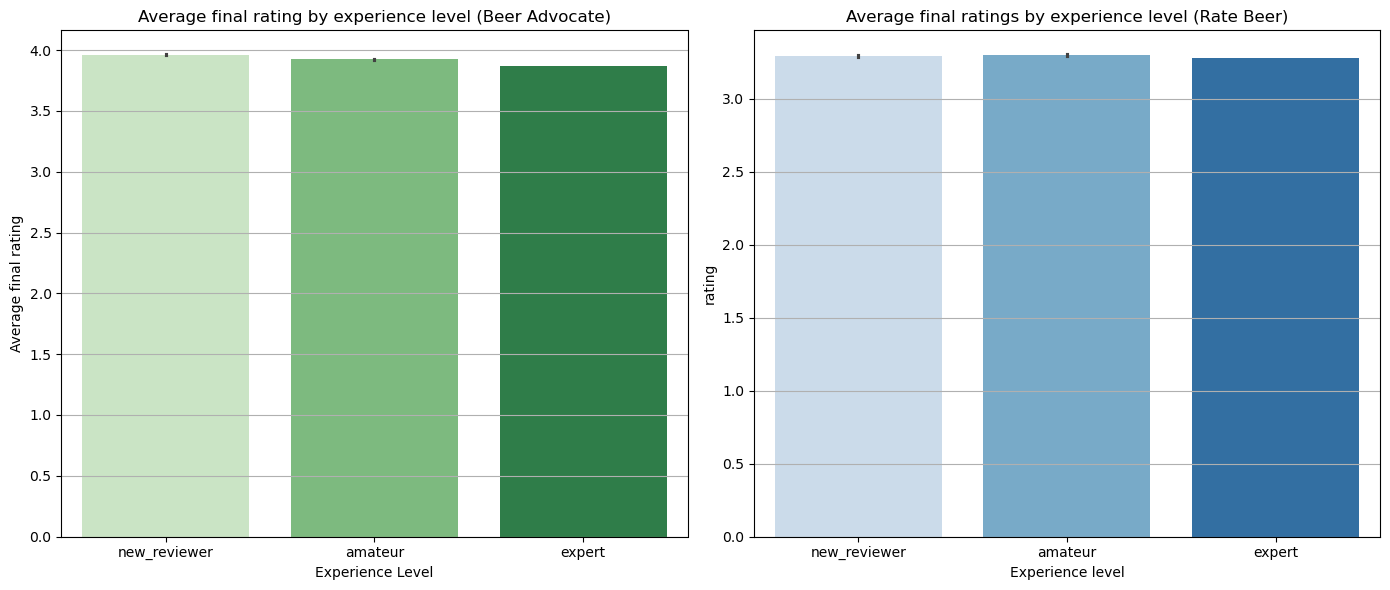

In [78]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='experience_level', y='rating', data=ba_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Greens')
plt.title('Average final rating by experience level (Beer Advocate)')
plt.xlabel('Experience Level')
plt.ylabel('Average final rating')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
sns.barplot(x='experience_level', y='rating', data=rb_ratings_with_experience_levels, order=['new_reviewer', 'amateur', 'expert'], ci=95, palette='Blues')
plt.title('Average final ratings by experience level (Rate Beer)')
plt.xlabel('Experience level')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
plt.close()

For both Beer Advocate and Beer Review data, we can see that the average final rating given by "expert" users is slightly smaller than that given by "new reviewers". While the difference is small, the confidence itervals do not overlap, suggesting that the differences, despite being small, may be significant.

Let us investigate this phenomenon further by examining how final ratings evolve with experience when considering users separately. To do so, we will test whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user, using a one-tailed t-test.

In [81]:
# Beer Advocate
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
ba_average_final_rating_by_user_and_experience_level = ba_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(ba_average_final_rating_by_user_and_experience_level['new_reviewer'], ba_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")

else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

T-statistic: 11.546972007985525, One-tailed P-value: 4.279385395467664e-31


In [82]:
# Rate Beer
# group the data by 'user_id' and 'experience_level' to calculate the average rating for each experience level and for each user
rb_average_final_rating_by_user_and_experience_level = rb_ratings_with_experience_levels.groupby(['user_id', 'experience_level'])['rating'].mean().unstack()

# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['new_reviewer'], rb_average_final_rating_by_user_and_experience_level['expert'])

if t_stat > 0:  # case where 'new reviewer' average rating is greater than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is smaller than 'expert' average rating
    print('No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.')

No support found for the alternative hypothesis that new_reviewer ratings are greater than expert ratings.


Given the output for the Rate Beer data, let us instead test whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user.

In [83]:
# perform a one-tailed t-test
t_stat, p_value = ttest_rel(rb_average_final_rating_by_user_and_experience_level['expert'], rb_average_final_rating_by_user_and_experience_level['new_reviewer'])

if t_stat > 0:  # case where 'new reviewer' average rating is lower than 'expert' average rating
    one_tailed_p_value = p_value / 2
    print(f"T-statistic: {t_stat}, One-tailed P-value: {one_tailed_p_value}")
    
else: # case where 'new reviewer' average rating is larger than 'expert' average rating
    print('No support found for the alternative hypothesis that expert ratings are greater than new_reviewer ratings.')

T-statistic: 13.625526413709126, One-tailed P-value: 2.635403140036256e-42


The one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is greater than the average rating of reviews labeled as 'expert' for a given user performed on the Beer Advocate data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is higher than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly higher than the mean of the expert ratings.

In contrast, the one-tailed t-test testing whether the average rating of reviews labeled as 'new_reviewer' is lower than the average rating of reviews labeled as 'expert' for a given user performed on the Rate Beer data yielded a positive test statistic, which suggests that the mean of new reviewer ratings is lower than the mean of expert ratings. The p-value is extremely small (p_value << 0.05), which means that the mean of the new_reviewer ratings is significantly lower than the mean of the expert ratings.

While these results appear contradictory, it is important to note that they were calculated on data from 40,000 users in Beer Advocate versus 14,000 users in Rate Beer. The larger sample size in Beer Advocate may make the corresponding results more representative of user behavior. However, these differences could also reflect distinct user rating cultures (especially since the ditribution of origins of reviewers from the 2 platforms differ significantly) or rating scales between the platforms. Thus, while we cannot conclude with certainty that users become more critical with experience across all platforms, the Beer Advocate data might suggest a trend in this direction. Further analysis with more data from both platforms or additional datasets could clarify if these patterns are platform-specific or represent a broader trend.